In [81]:
%run generate_matrices.ipynb     # importing functions
%run closest_versus_minimal.ipynb     # importing functions

In [106]:
def descent(jsonfilename):
    cases = from_json(jsonfilename)
    reached = 0
    pathways = []
    for case in cases:
        r, pathway = descent_single(case)
        if r: reached += 1
        pathways.append(pathway)
    return reached, len(cases) - reached, pathways

def descent_single(case):
    pathway = []
    B, lc_cube, lc_LLL = case["B"], case["lincomb_cube"], case["lincomb_LLL"]        
    pathway.append(lc_LLL)
    minimal = evaluate_norms_at_cube(cube_points(lc_cube), B)[0][1]
    center = minimal
    central_norm = (vector(minimal)*matrix(B)).norm().n()
    while True :
        pathway.append(center)
        big_cube = big_cube_points(minimal)
        bigCubeMinimum = evaluate_norms_at_cube(big_cube, B)[0][1]
        if center == bigCubeMinimum:
            pathway.append(lc_cube)
            reached = False
            break # this part is faulty I believe. 
        elif bigCubeMinimum == lc_LLL:
            reached = True
            break
        center = bigCubeMinimum
    return reached, pathway

def big_cube_points(int_combination):
    points = []
    for i in range((len(int_combination))):
            dupe = int_combination[:]
            dupe[i] += 1
            points.append(copy(dupe))
            dupe[i] -= 2
            points.append(copy(dupe))
    points = [list(map(lambda x : int(x), point)) for point in points]
#     print("big cube points", points)
    return points

def vector_difference(u, v):
    difference = 0
    for a, b in zip(u, v):
        difference += abs(a - b)
    return difference

In [105]:
a, b, _ = descent("matrices6x6-600instances.json")


print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(a, b, 100*a/(a+b).n(digits=3)))

Reached the same LC as LLL in 15 cases, havent reached in 582 cases, success rate 2.51.


In [84]:
c, d, _ = descent("matrices3x3-600instances.json")

print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(c, d, 100*c/(c+d).n(digits=3)))

Reached the same LC as LLL in 143 cases, havent reached in 532 cases, success rate 21.2.


What if I start the ascent in the closest point? It doesnt make much sense, as I am not able to compute the closest point without knowledge of the LLL linear combination, but im just curious rn.

In [85]:
def descent_from_closest(jsonfilename):
    cases = from_json(jsonfilename)
    reached = 0
    for case in cases:
        B, lc_cube, lc_LLL = case["B"], case["lincomb_cube"], case["lincomb_LLL"]
        minimal =  closest_point_in_cube(lc_cube, lc_LLL)
        center = minimal
        central_norm = (vector(minimal)*matrix(B)).norm().n()
        while True :
            big_cube = big_cube_points(minimal)
            bigCubeMinimum = evaluate_norms_at_cube(big_cube, B)[0][1]
            if center == bigCubeMinimum:
                break
            if bigCubeMinimum == lc_LLL:
                reached += 1
            center = bigCubeMinimum
    return reached, len(cases) - reached


In [86]:
e, f = descent_from_closest("matrices6x6-600instances.json")

print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(e, f, 100*e/(e+f).n(digits=3)))


g, h = descent_from_closest("matrices3x3-600instances.json")


print("Reached the same LC as LLL in {} cases, havent reached in {} cases, success rate {}.".format(g, h, 100*g/(g+h).n(digits=3)))


Reached the same LC as LLL in 48 cases, havent reached in 549 cases, success rate 8.04.
Reached the same LC as LLL in 555 cases, havent reached in 120 cases, success rate 82.2.


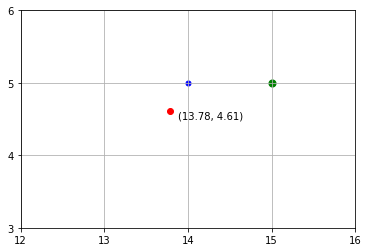

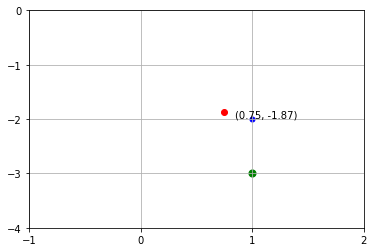

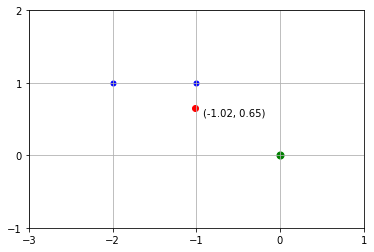

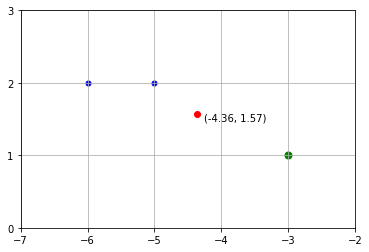

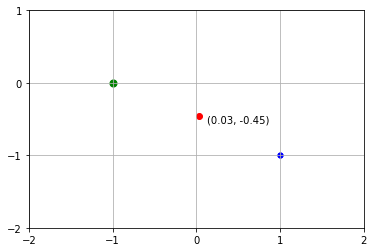

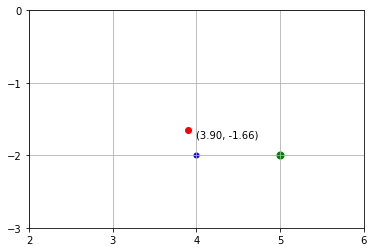

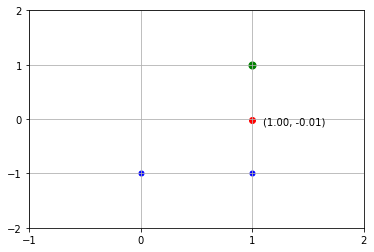

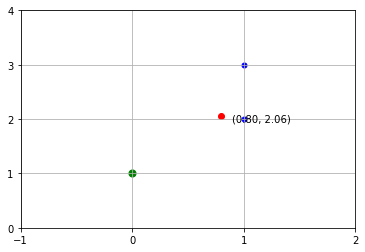

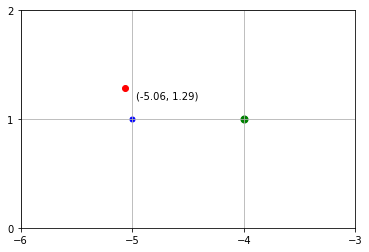

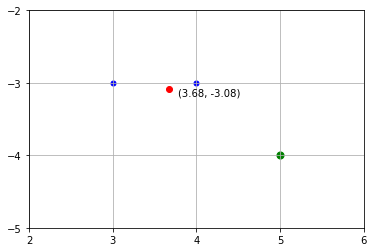

In [95]:
# This part of code is meant to generate the precise points the algorithm took during the descent. 

_, _, pathways = descent("matrices3x3-600instances.json")


import matplotlib.pyplot as plt

def different_components(pathway):
    diff_indices = set(range(len(pathway[0])))
    
    for i in range(len(pathway[0])):
        unique_values = {point[i] for point in pathway}
        if len(unique_values) == 1:
            diff_indices.remove(i)

    return list(diff_indices)

def plot_pathway(pathway):
    diff_indices = different_components(pathway)

    x = [point[diff_indices[0]] for point in pathway]
    y = [point[diff_indices[1]] for point in pathway]

    # Create the plot
    plt.scatter(x[1:-1], y[1:-1], color='blue',s=25)
    plt.scatter(x[0], y[0], color='green',s=50)  # Highlight the first point in green
    plt.scatter(x[-1], y[-1], color='red')  # Highlight the last point in red

    # Add description next to the red point
    description = f"({x[-1]:.2f}, {y[-1]:.2f})"
    plt.text(x[-1] + 0.1, y[-1] - 0.1, description)

    # Add gridlines corresponding to integers
    plt.grid(True, which='both')

    # Set axis ticks to integers only
    plt.xticks(range(int(min(x)) - 1, int(max(x)) + 2))
    plt.yticks(range(int(min(y)) - 1, int(max(y)) + 2))

    # Show the plot
    plt.show()



# for pathway in pathways[:10]:
#     plot_pathway(pathway)
